In [37]:
import numpy as np
import networkx as nx
import itertools
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt

In [11]:
Cities = ["London", "Manchester", "Birmingham", "Leeds", "Glasgow"]

distances = [[0,262,162,272,555], [262,0,113,59,295], [162,113,0,148,407], [272,59,148,0,288], [555,295,407,288,0]]

# create a dictionary of cities
cities_dict = {i : {} for i in Cities}

# connect all cities with distances
for e in Cities:  
    cities_dict[e] = {i : distances[Cities.index(e)][Cities.index(i)] for i in Cities}

print(cities_dict)

{'London': {'London': 0, 'Manchester': 262, 'Birmingham': 162, 'Leeds': 272, 'Glasgow': 555}, 'Manchester': {'London': 262, 'Manchester': 0, 'Birmingham': 113, 'Leeds': 59, 'Glasgow': 295}, 'Birmingham': {'London': 162, 'Manchester': 113, 'Birmingham': 0, 'Leeds': 148, 'Glasgow': 407}, 'Leeds': {'London': 272, 'Manchester': 59, 'Birmingham': 148, 'Leeds': 0, 'Glasgow': 288}, 'Glasgow': {'London': 555, 'Manchester': 295, 'Birmingham': 407, 'Leeds': 288, 'Glasgow': 0}}


In [68]:
# maybe better: create a full mesh then disconnect one by one in a loop

G=nx.Graph()
G.add_nodes_from(Cities)
for i in cities_dict:
    for j in cities_dict[i]:
        G.add_weighted_edges_from([(i,j,cities_dict[i][j])])
        # G.add_edges_from([(i,j,{'distance':cities_dict[i][j]})])

# remove self-edges
G.remove_edges_from(nx.selfloop_edges(G))

# add atrributes
# G.edge['London']['Manchester']['attribute'] = 'value'

In [69]:
G.nodes()

NodeView(('London', 'Manchester', 'Birmingham', 'Leeds', 'Glasgow'))

In [86]:
G.edges()

EdgeView([('London', 'Manchester'), ('London', 'Birmingham'), ('London', 'Leeds'), ('London', 'Glasgow'), ('Manchester', 'Birmingham'), ('Manchester', 'Leeds'), ('Manchester', 'Glasgow'), ('Birmingham', 'Leeds'), ('Birmingham', 'Glasgow'), ('Leeds', 'Glasgow')])

In [71]:
G['Manchester']

AtlasView({'London': {'weight': 262}, 'Birmingham': {'weight': 113}, 'Leeds': {'weight': 59}, 'Glasgow': {'weight': 295}})

{'London': Text(0.9999999999999999, 2.38418583364819e-08, 'London'),
 'Manchester': Text(0.30901696042448806, 0.9510565808604344, 'Manchester'),
 'Birmingham': Text(-0.8090170945349412, 0.587785218735669, 'Birmingham'),
 'Leeds': Text(-0.8090169753256495, -0.5877853498658898, 'Leeds'),
 'Glasgow': Text(0.30901710943610267, -0.9510564735720718, 'Glasgow')}

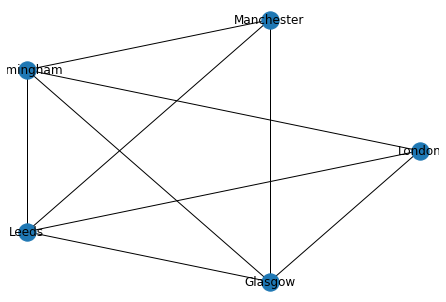

In [88]:
nx.draw(G, pos=nx.circular_layout(G))
nx.draw_networkx_labels(G,pos=nx.circular_layout(G))
# nx.draw_networkx_edge_labels(G,pos=nx.circular_layout(G)) 

In [52]:
# develop a method to drop them out one by one in a loop through all possibilities and then pairwise and so 
# on until 5 at a time (max)

# for i in Cities:
#     for j in G.neighbours(i):
#         G.remove_edge(i,j)

In [87]:
G.remove_edge('London','Manchester')

In [90]:
# calculate values:

# 1) shortest path between any two nodes
path_lengths = nx.all_pairs_dijkstra_path_length(G)
print(dict(path_lengths))
paths = nx.all_pairs_dijkstra_path(G)
print(dict(paths))
# 2) decide amplifier locations - these should be roughly equally spaced, calc mean and longest paths
# above a certain loss value (?) so length need an amplifier, above another - two amplifiers
print(nx.diameter(G), nx.radius(G))


{'London': {'London': 0, 'Birmingham': 162, 'Leeds': 272, 'Manchester': 275, 'Glasgow': 555}, 'Manchester': {'Manchester': 0, 'Leeds': 59, 'Birmingham': 113, 'London': 275, 'Glasgow': 295}, 'Birmingham': {'Birmingham': 0, 'Manchester': 113, 'Leeds': 148, 'London': 162, 'Glasgow': 407}, 'Leeds': {'Leeds': 0, 'Manchester': 59, 'Birmingham': 148, 'London': 272, 'Glasgow': 288}, 'Glasgow': {'Glasgow': 0, 'Leeds': 288, 'Manchester': 295, 'Birmingham': 407, 'London': 555}}
{'London': {'London': ['London'], 'Birmingham': ['London', 'Birmingham'], 'Leeds': ['London', 'Leeds'], 'Glasgow': ['London', 'Glasgow'], 'Manchester': ['London', 'Birmingham', 'Manchester']}, 'Manchester': {'Manchester': ['Manchester'], 'Birmingham': ['Manchester', 'Birmingham'], 'Leeds': ['Manchester', 'Leeds'], 'Glasgow': ['Manchester', 'Glasgow'], 'London': ['Manchester', 'Birmingham', 'London']}, 'Birmingham': {'Birmingham': ['Birmingham'], 'London': ['Birmingham', 'London'], 'Manchester': ['Birmingham', 'Manchester']

In [3]:
#now create all possible networks with nodes of degree >= 2 - how many possibilities?

# connected_list = []
# for i in Cities:
#     for j in Cities:
#         if j!=i:
#             connected_list.append([i,j])

repeated_list = [[a,b] for a,b in zip(Cities,Cities)]
print(repeated_list)

[['London', 'London'], ['Manchester', 'Manchester'], ['Birmingham', 'Birmingham'], ['Leeds', 'Leeds'], ['Glasgow', 'Glasgow']]


In [4]:
connection_list = []
permut = itertools.permutations(Cities, len(Cities))

for comb in permut:
    zipped = zip(comb, Cities)
    connection_list.append(list(zipped))

#filter out 1to1 connections

remove = []

for i in connection_list:
    for j in i:
        if j[0] == j[1]:
            if i not in remove:
                remove.append(i)
                
for i in remove:
    connection_list.remove(i)

print(connection_list)

for i in connection_list:
    seen = set()
    result = []
    for d in i:
        if frozenset(d) not in seen:
            result.append(d)
            seen.add(frozenset(d))
    if result != i:
        print(i)
        connection_list.remove(i)
        
print(connection_list)

[[('Manchester', 'London'), ('London', 'Manchester'), ('Leeds', 'Birmingham'), ('Glasgow', 'Leeds'), ('Birmingham', 'Glasgow')], [('Manchester', 'London'), ('London', 'Manchester'), ('Glasgow', 'Birmingham'), ('Birmingham', 'Leeds'), ('Leeds', 'Glasgow')], [('Manchester', 'London'), ('Birmingham', 'Manchester'), ('London', 'Birmingham'), ('Glasgow', 'Leeds'), ('Leeds', 'Glasgow')], [('Manchester', 'London'), ('Birmingham', 'Manchester'), ('Leeds', 'Birmingham'), ('Glasgow', 'Leeds'), ('London', 'Glasgow')], [('Manchester', 'London'), ('Birmingham', 'Manchester'), ('Glasgow', 'Birmingham'), ('London', 'Leeds'), ('Leeds', 'Glasgow')], [('Manchester', 'London'), ('Leeds', 'Manchester'), ('London', 'Birmingham'), ('Glasgow', 'Leeds'), ('Birmingham', 'Glasgow')], [('Manchester', 'London'), ('Leeds', 'Manchester'), ('Glasgow', 'Birmingham'), ('London', 'Leeds'), ('Birmingham', 'Glasgow')], [('Manchester', 'London'), ('Leeds', 'Manchester'), ('Glasgow', 'Birmingham'), ('Birmingham', 'Leeds'),